In [1]:
import sys
import os
import warnings

# Ajouter le répertoire parent pour inclure 'src'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

# Imports après avoir ajusté le sys.path
from src.backtester.back_tester import BackTesting
from src.strategies.strategies import *
from src.utils.utilities import Utilities
from src.performance.graph import IndexPlotter
import src.utils.config as config
from src.performance.metrics import MetricsCalculator

# Supprimer les avertissements FutureWarning et RuntimeWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.float_format', '{:.3f}'.format)

<div style="background-color: rgb(15, 50, 110); color: white; padding: 15px; border-radius: 8px; box-shadow: 0 3px 6px 0 rgba(0, 0, 0, 0.2); text-align: center;">
    <h1 style="font-size: 32px; font-weight: bold; margin: 0;">Volatility Timing under Low-Volatility Strategy</h1>
</div> 

## <span style="color: rgb(15, 50, 150); font-size: 20px; font-weight: bold;"> Volatility Strategies </span>

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;"> 1. Strategies construction and back-testing </span>

In [2]:
# Paramètres du back-test
params = {
    "currency": config.CURRENCY,
    "start_date": config.START_DATE,
    "end_date": config.END_DATE,
    "ticker": config.TICKER,
    "strategy": VolatilityTimingStrategy(),
    "use_pickle_universe": config.USE_PICKLE_UNIVERSE,
}

# Lancement du back-test
asset_index = BackTesting.start(params)
#Utilities.save_data_to_pickle(asset_index, file_name="VolatilityTiming",folder_subpath="asset_indices\\monthly_eq_weighted")

Processing date: 2000-01-31
Processing date: 2000-02-29
Processing date: 2000-03-31
Processing date: 2000-04-28
Processing date: 2000-05-31
Processing date: 2000-06-30
Processing date: 2000-07-31
Processing date: 2000-08-31
Processing date: 2000-09-29
Processing date: 2000-10-31
Processing date: 2000-11-30
Processing date: 2000-12-29
Processing date: 2001-01-31
Processing date: 2001-02-28
Processing date: 2001-03-30
Processing date: 2001-04-30
Processing date: 2001-05-31
Processing date: 2001-06-29
Processing date: 2001-07-31
Processing date: 2001-08-31
Processing date: 2001-09-28
Processing date: 2001-10-31
Processing date: 2001-11-30
Processing date: 2001-12-31
Processing date: 2002-01-31
Processing date: 2002-02-28
Processing date: 2002-03-28
Processing date: 2002-04-30
Processing date: 2002-05-31
Processing date: 2002-06-28
Processing date: 2002-07-31
Processing date: 2002-08-30
Processing date: 2002-09-30
Processing date: 2002-10-31
Processing date: 2002-11-29
Processing date: 200

In [4]:
# Appel de la fonction port
# asset_index = Utilities.get_data_from_pickle('VolatilityTiming',folder_subpath="asset_indices\\monthly_eq_weighted")
# asset_index.get_port_file('VolatilityTiming')

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;"> 2. Volatility and Return Profile under Different Market Conditions </span>

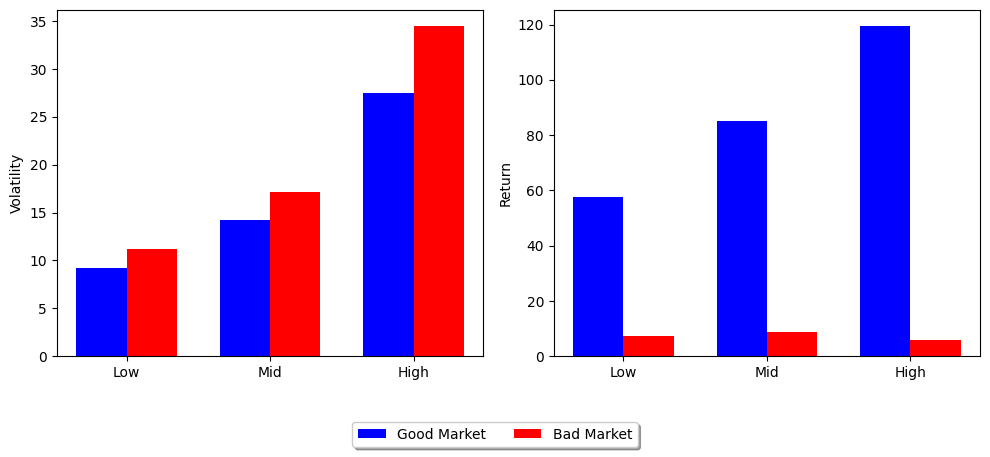

In [5]:
asset_indices_monthly = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile"], 
                                             folder_subpath="asset_indices\\monthly_eq_weighted")
other_data = Utilities.get_data_from_pickle('other_US_data')
IndexPlotter.asset_indices_plot_under_diff_conditions(asset_indices_monthly,other_data)

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;"> 3. Performance and Wealth Plots of the Volatility Strategies </span>

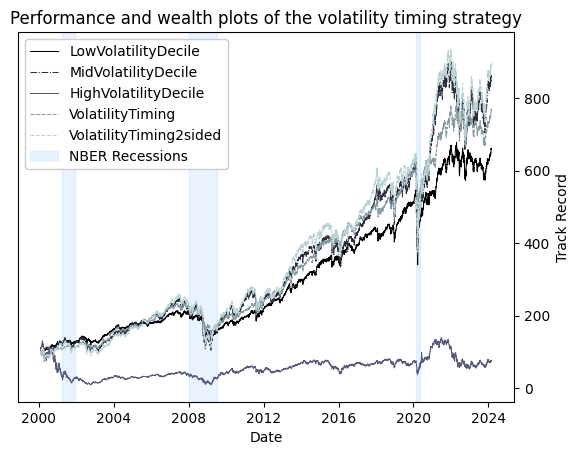

In [6]:
# Graph des tracks records des stratégies
asset_indices_monthly = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile", 
                                              "VolatilityTiming", "VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\monthly_eq_weighted")
other_data = Utilities.get_data_from_pickle('other_US_data')
IndexPlotter.plot_track_records(asset_indices_monthly, other_data['USRINDEX Index'])

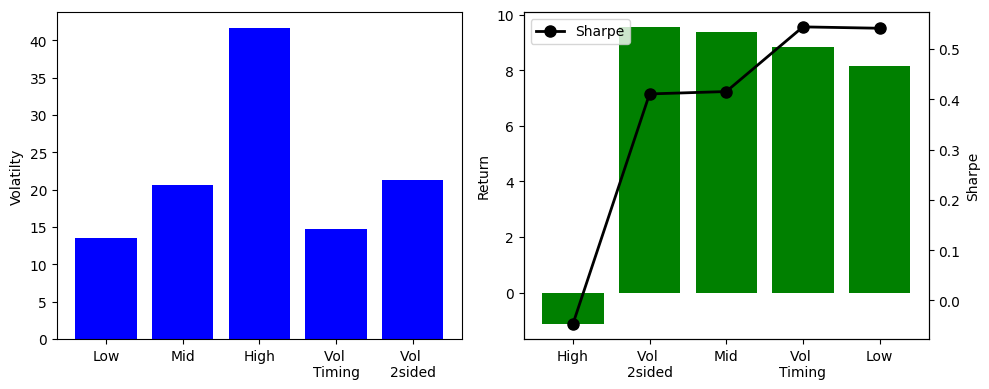

In [7]:
IndexPlotter.asset_indices_barplot(asset_indices_monthly, other_data)

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  4. Performance and Risk Measures of the Various Volatility Portfolios </span>

In [8]:
IndexPlotter.display_asset_indices_metrics(asset_indices_monthly,other_data)

,Low Volatility,Mid Volatility,High Volatility,Volatility Timing,Volatility Timing 2-sided
Return,8.16%,9.39%,-1.14%,8.85%,9.56%
Volatility,13.55%,20.60%,41.70%,14.74%,21.25%
Sharpe Ratio,0.542,0.416,-0.047,0.544,0.411
Max Drawdown,-39.98%,-57.78%,-93.28%,-39.98%,-57.78%
SQRT (Semi-variance),11.23%,16.24%,30.20%,12.56%,16.98%
Sortino Ratio,0.653,0.527,-0.065,0.638,0.514
Information Ratio,Benchmark,1.638,-4.068,1.870,1.702


## <span style="color: rgb(15, 50, 150); font-size: 20px; font-weight: bold;"> Robustness Tests </span>


### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  1. CAPM and Fama–French Alphas </span>

In [9]:
CPAM_stats, FF_stats = IndexPlotter.display_regress_statistics(asset_indices_monthly)
CPAM_stats

,α (%),β_mkt,R²
LowVol,0.411**,0.505**,0.529
,(2.901),(9.639),
MidVol,0.297*,1.002**,0.801
,(1.697),(16.907),
HighVol,-0.644*,2.091**,0.676
,(-1.689),(13.430),
VolTiming,0.445**,0.567**,0.501
,(2.702),(11.200),
Vol2Sided,0.303,1.040**,0.780
,(1.580),(18.942),


In [10]:
FF_stats

,α (%),β_mkt,β_SMB,β_HML,R²
LowVol,0.374**,0.546**,-0.190**,0.208**,0.627
,(3.437),(12.823),(-3.704),(3.343),
MidVol,0.217*,1.014**,-0.024,0.403**,0.877
,(1.882),(28.013),(-0.215),(6.119),
HighVol,-0.636*,1.894**,0.997**,-0.171,0.751
,(-1.928),(12.747),(6.876),(-0.897),
VolTiming,0.414**,0.601**,-0.157**,0.172**,0.552
,(2.991),(12.342),(-3.007),(2.560),
Vol2Sided,0.228*,1.045**,0.011,0.370**,0.837
,(1.707),(21.634),(0.099),(5.941),


### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  2. Performance plots for various rebalancing frequencies </span>

In [11]:
# Chargement des indices
asset_indices_quaterly = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile", 
                                              "VolatilityTiming", "VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\quarterly_eq_weighted")
asset_indices_semiannually = Utilities.load_asset_indices(["VolatilityTiming"],
                                             folder_subpath="asset_indices\\semiannually_eq_weighted")
asset_indices_annually = Utilities.load_asset_indices(["VolatilityTiming"],
                                             folder_subpath="asset_indices\\annually_eq_weighted")

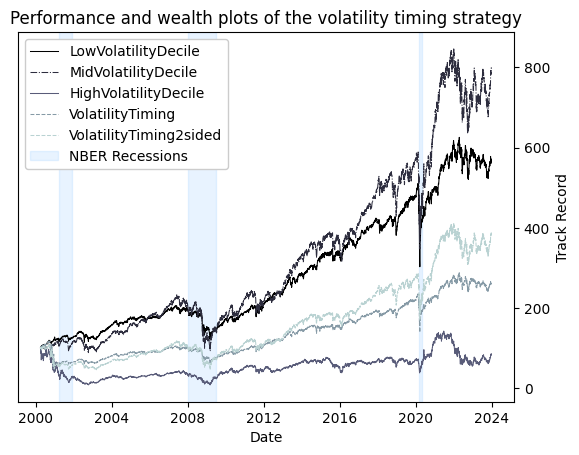

In [12]:
# Graph des tracks records des stratégies : rebalancement trimestriel (fin trimestre)
IndexPlotter.plot_track_records(asset_indices_quaterly, other_data['USRINDEX Index'])

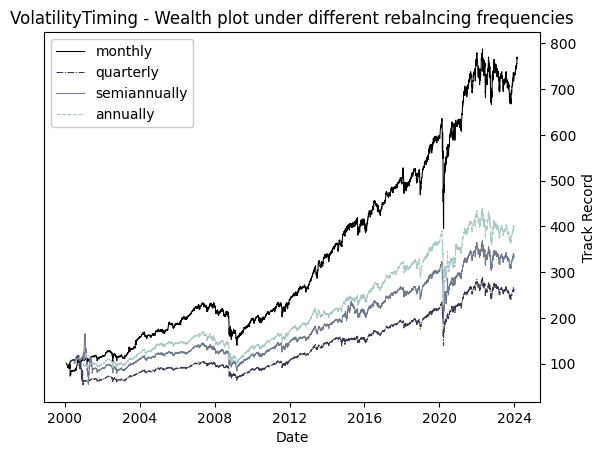

In [13]:
# Graphique des tracks records de la stratégie VolTiming pour différentes fréquences de rebalancement
IndexPlotter.plot_tracks_for_diff_rebalncing_freq( [asset_indices_monthly['VolatilityTiming'],
                                                   asset_indices_quaterly['VolatilityTiming'],
                                                   asset_indices_semiannually['VolatilityTiming'],
                                                   asset_indices_annually['VolatilityTiming']],
                                                   label_names=["monthly", "quarterly","semiannually","annually"],
                                                   strat_name="VolatilityTiming")